# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [583]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [584]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [585]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [586]:
#your turn

#pivoting df_transactions
df_aux = df_transactions.pivot_table(index = 'customer_name', columns = 'offer_id', values='n', fill_value = 0)

# creating new required dataframe
df_new = pd.DataFrame()
df_new['customer_name'] = df_aux.index

for k in df_aux.columns:
    df_new[k] = df_aux[k].values

#df_new.info()

del df_aux
df_new.head()

,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

The best values of SS are those that are not very close to zero (since if each point is a centroid of its own cluster, SS is identically zero), and at the same time much smaller than the value of SS representing all points as a single cluster. These are the values for K near the elbow point. K for good clustering must be much smaller than the total number of points but at the same time not too large.

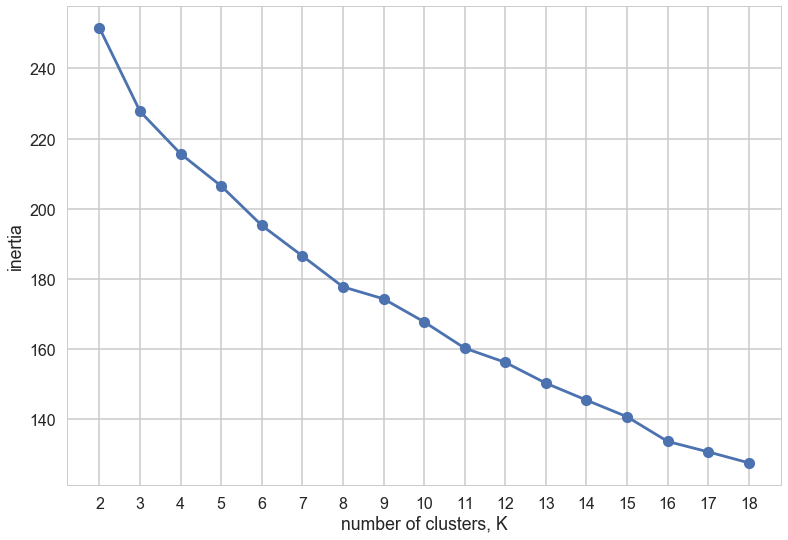

In [587]:
# your turn
x_cols = df_new.as_matrix(columns = [k for k in range(1,33)])

#x_cols.shape

# K-means clustering
from sklearn.cluster import KMeans

ks = range(2, 19)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters = k)
    
    # Fit model to x_cols
    kmeans.fit(x_cols)

    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, K')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

It is not very easy to choose the right K from the graph above, because the elbow is not very well expressed; the graph resembles the combination of two straight lines with different slopes that intersect near the point K = 4. So the most sensible value of K is 4, if this method is used.

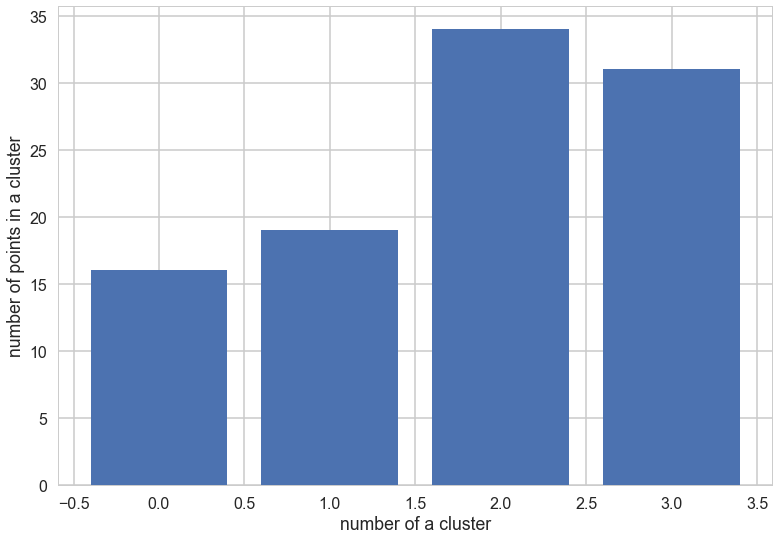

In [588]:
kmeans4 = KMeans(n_clusters = 4)
    
#Fit_transform model to x_cols
result = kmeans4.fit_predict(x_cols)

# print(result)

number_of_cluster = [k for k in range(0, 4)]
number_of_points = [ np.sum(result == k) for k in range(0, 4)]

# printing the bar chart
plt.bar(number_of_cluster, number_of_points)
plt.xlabel('number of a cluster')
plt.ylabel('number of points in a cluster')
plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.0936557328349


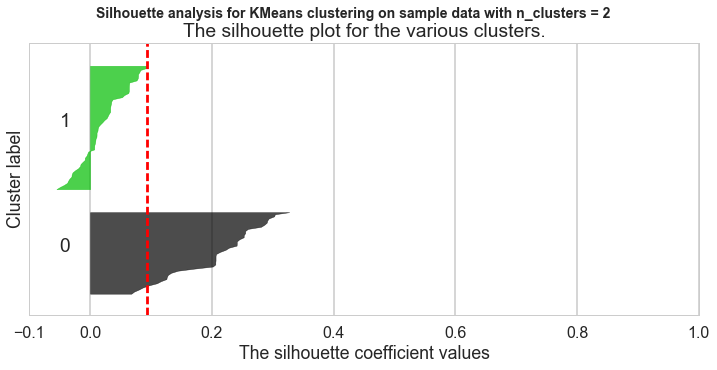

For n_clusters = 3 The average silhouette_score is : 0.118899428636


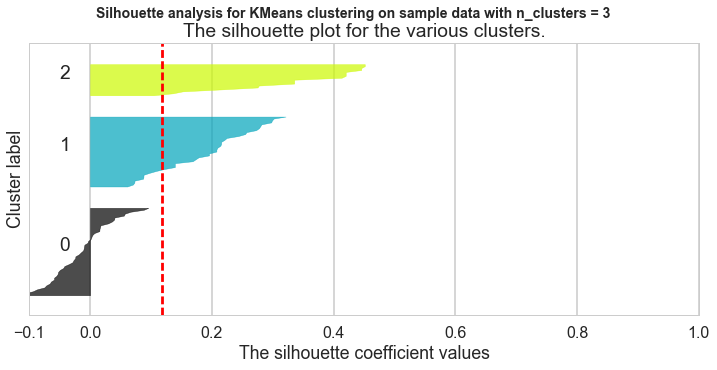

For n_clusters = 4 The average silhouette_score is : 0.123470539196


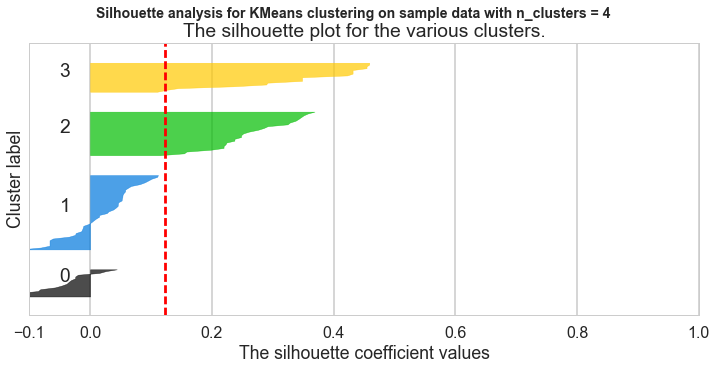

For n_clusters = 5 The average silhouette_score is : 0.14092516242


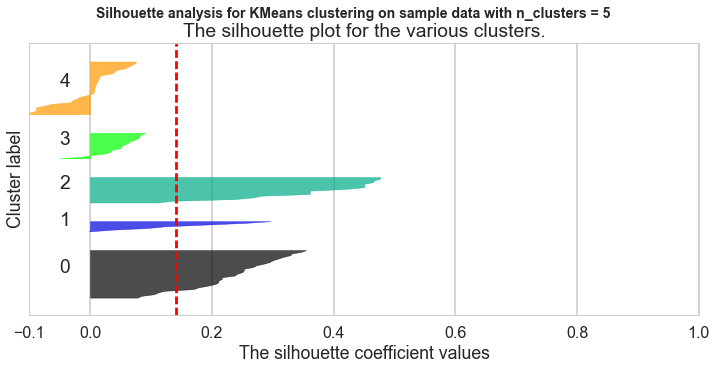

For n_clusters = 6 The average silhouette_score is : 0.137179893911


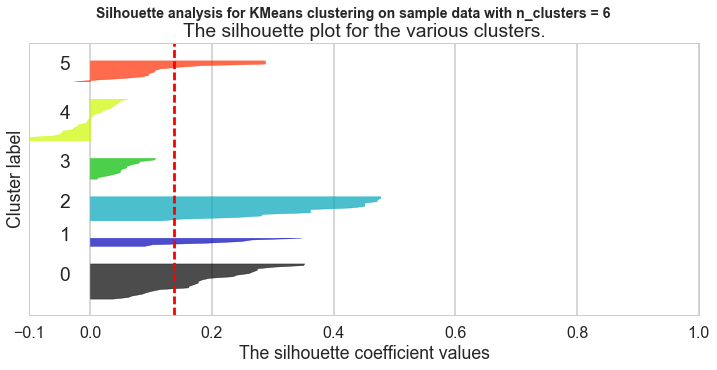

For n_clusters = 7 The average silhouette_score is : 0.116109245662


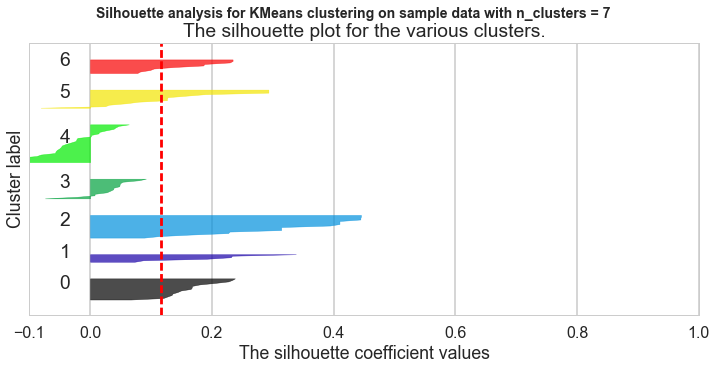

For n_clusters = 8 The average silhouette_score is : 0.113395738326


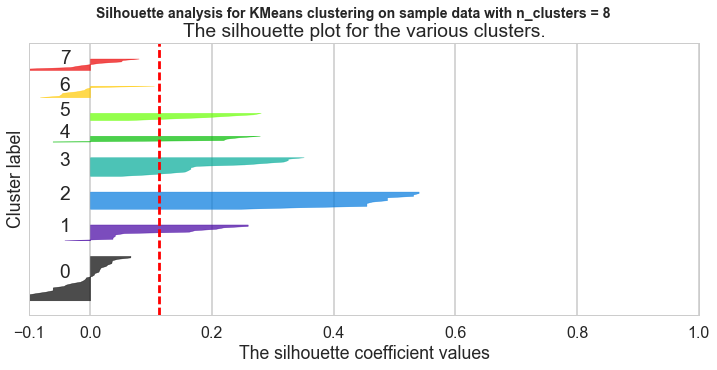

For n_clusters = 9 The average silhouette_score is : 0.125059605278


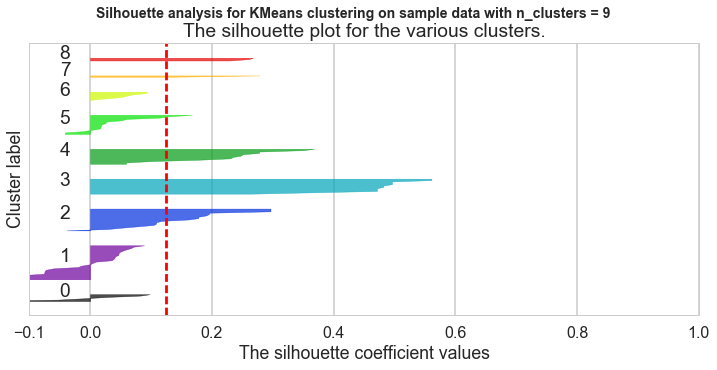

For n_clusters = 10 The average silhouette_score is : 0.119283321348


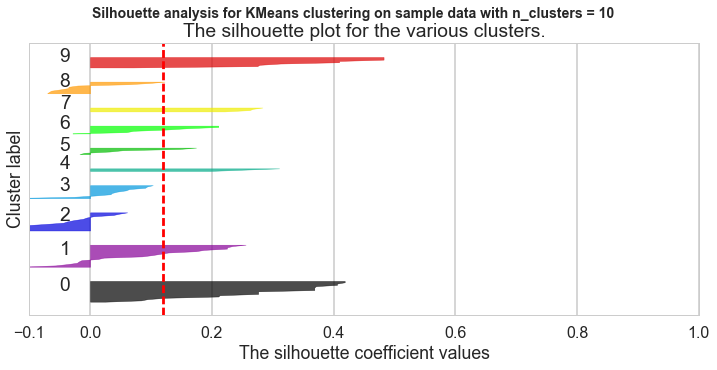

In [589]:
# Your turn.
from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # Labeling the clusters
    centers = clusterer.cluster_centers_

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

The silhouette plots for various clusters and the calculations of the average silhouette scores show that the scores are very low. They are smaller than 0.25 which is indicative of the absence of substantial structure. The highest score is for K = 5, and the value of K = 5, if chosen as the optimal one for best clustering, does not coincides with that obtained from naive Elbow method, where I chose K = 4. Overall analysis shows that the current data present difficulty finding a reliable way to separate them into clusters.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

Let's create the required data frame and make the scatter plot assuming K = 4. From the scatter plot provided below we see that the points with the cluster id's equal to 3 and 1 are well separated from the rest of the group, while those with the cluster id's equal to 2 and 0 have a region of mutual interpenetration. Overall, we see that choosing K = 4 from the Elbow method is probably the best choice, as seen from the visualization based on just two principal components. We should note, though, that keeping just two components cathes about 70 percent of the total variance, which is not bad but may tell us that two is not the best value for reduced dimensionality. 

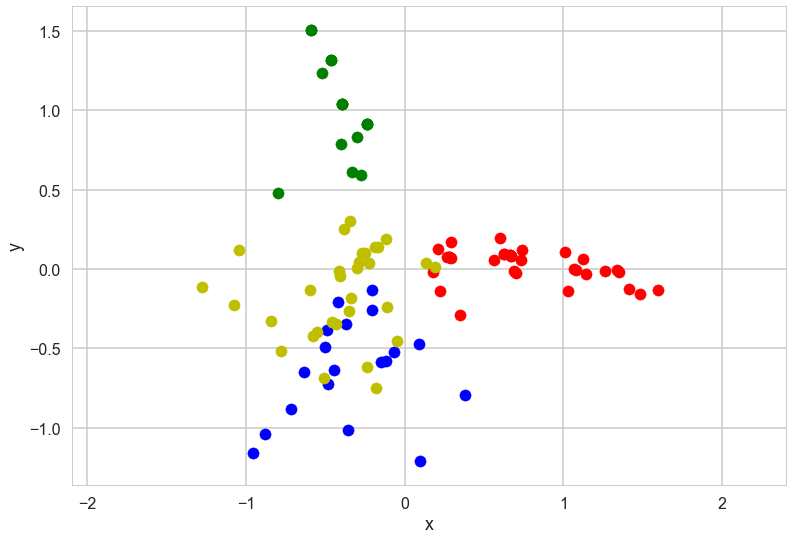

In [590]:
#your turn
from sklearn.decomposition import PCA

model_pca = PCA(n_components = 2)
model_pca.fit(x_cols)
pca_features = model_pca.transform(x_cols)

#print(pca_features)

# Assign 0th column of pca_features: xs
x = pca_features[:,0]
# Assign 1st column of pca_features: ys
y = pca_features[:,1]

# Creating the new required dataframe
df_pca = pd.DataFrame()
df_pca['customer_name'] = df_new['customer_name'].values
df_pca['cluster_id'] = result
df_pca['x'] = x
df_pca['y'] = y

# Scatter plot xs vs ys
plt.scatter(df_pca[df_pca['cluster_id'] == 0]['x'], df_pca[df_pca['cluster_id'] == 0]['y'], c = 'g')
plt.scatter(df_pca[df_pca['cluster_id'] == 1]['x'], df_pca[df_pca['cluster_id'] == 1]['y'], c = 'b')
plt.scatter(df_pca[df_pca['cluster_id'] == 2]['x'], df_pca[df_pca['cluster_id'] == 2]['y'], c = 'r')
plt.scatter(df_pca[df_pca['cluster_id'] == 3]['x'], df_pca[df_pca['cluster_id'] == 3]['y'], c = 'y')
#plt.scatter(df_pca[df_pca['cluster_id'] == 4]['x'], df_pca[df_pca['cluster_id'] == 4]['y'], c = 'c')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()


In [591]:
print('The explained variance is:', model_pca.explained_variance_ )

The explained variance is: [ 0.40555241  0.30446016]


To tell the story of what all the clustering we performed so far means, let's determine which wines were dominant for the customers belonging to each cluster id. We create the list of four lists, so that each list contains all wines bought by the customers having one of four assigned cluster ids. After that we count the numbers of each wine in each list, and thus determine the preferences of customers belonging to each cluster. 

The result is shown below, and it is very interesting. The customers from cluster 0 have a strong passion for Pinot Noir (red wine), while those from cluster 1 for Champaign. The customers from cluster 2 have rather diverse preferences: they like the Portugese Espumante followed by Prosecco, Malbec and Pino Grigio. At the same time, the customers from cluster 3 are in favour of Champaigne and Cabernet Sauvignion.

In [605]:
#wines_for_cluster = [ [] for _ in range(4)]
wines_for_cluster = [ [], [], [], [] ]

for i in range(4):
    for name in df_pca['customer_name'].values:
        if df_pca[df_pca['customer_name'] == name]['cluster_id'].values[0] == i:
            for j in range(1, 33):
                if df_new[df_new['customer_name'] == name][j].values[0] == 1:
                    wines_for_cluster[i].append(df_offers[df_offers['offer_id'] == j].varietal.values[0])
                

In [606]:
print('The customers from cluster 0 acquired:')
for entry in Counter(wines_for_cluster[0]).most_common():
    print(entry[0], ":", entry[1])
    
print('\n')
print('The customers from cluster 1 acquired:')
for entry in Counter(wines_for_cluster[1]).most_common():
    print(entry[0], ":", entry[1])
    
print('\n')
print('The customers from cluster 2 acquired:')
for entry in Counter(wines_for_cluster[2]).most_common():
    print(entry[0], ":", entry[1])
    
print('\n')
print('The customers from cluster 3 acquired:')
for entry in Counter(wines_for_cluster[3]).most_common():
    print(entry[0], ":", entry[1])

The customers from cluster 0 acquired:
Pinot Noir : 37
Prosecco : 2
Merlot : 1
Malbec : 1
Chardonnay : 1
Champagne : 1


The customers from cluster 1 acquired:
Champagne : 41
Prosecco : 17
Espumante : 10
Cabernet Sauvignon : 5
Chardonnay : 3
Merlot : 2


The customers from cluster 2 acquired:
Espumante : 30
Prosecco : 19
Pinot Grigio : 16
Malbec : 16
Merlot : 6
Champagne : 2
Cabernet Sauvignon : 1


The customers from cluster 3 acquired:
Champagne : 37
Cabernet Sauvignon : 26
Malbec : 15
Chardonnay : 11
Merlot : 11
Pinot Noir : 7
Prosecco : 5
Pinot Grigio : 1


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

One can see from the figure below that retaining three components is definitely better than two.

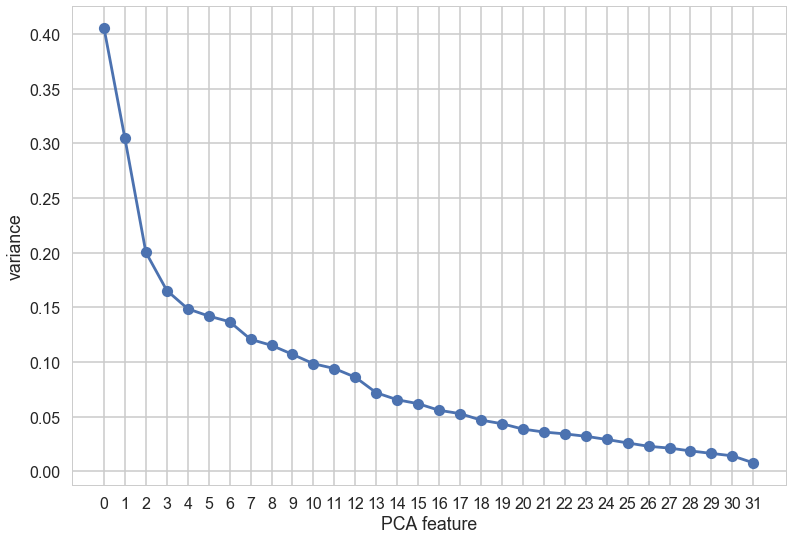

In [607]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)

features = range(pca.n_components_)

plt.plot(features, pca.explained_variance_, '-o')
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [557]:
# Your turn

### Affinity propagation

It is important to notice that the number of clusters strongly depends on the damping and preference parameters. I managed to choose those parameters in such a way that the number of clusters remains 4. The Silhouette Coefficient is low, and plotting the clusters based on two pricipal components shows that the picture of clusters is less sensible than that obtained using KMeans method. The use of the method with default parameters gives the optimal number of clusters equal to 14, albeight a slightly higher Silhouette Coefficient.

In [615]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

#af = AffinityPropagation().fit(x_cols)
af = AffinityPropagation(damping = 0.8, preference = -21).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

result_af = af.predict(x_cols)

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(x_cols2, labels, metric='sqeuclidean'))



Estimated number of clusters: 4
Silhouette Coefficient: 0.127


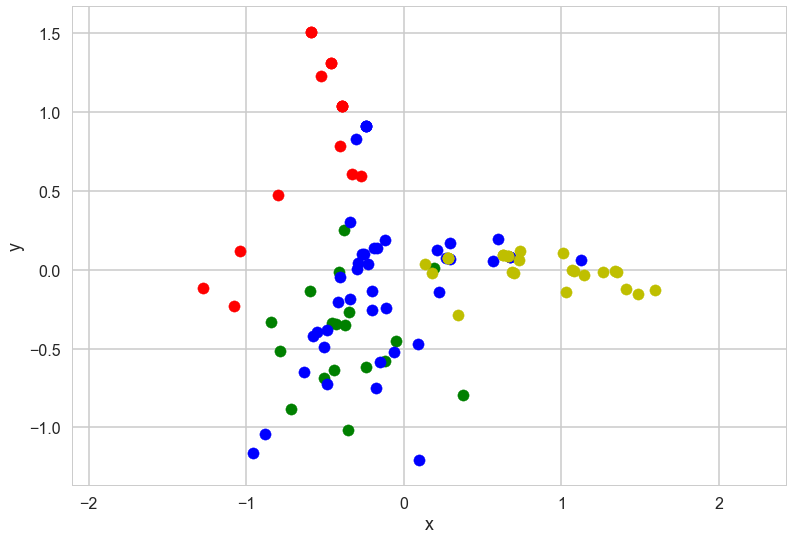

In [616]:
df_plot = pd.DataFrame()
df_plot['cluster_id'] = result_af
df_plot['x'] = x
df_plot['y'] = y

plt.scatter(df_plot[df_plot['cluster_id'] == 0]['x'], df_plot[df_plot['cluster_id'] == 0]['y'], c = 'g')
plt.scatter(df_plot[df_plot['cluster_id'] == 1]['x'], df_plot[df_plot['cluster_id'] == 1]['y'], c = 'b')
plt.scatter(df_plot[df_plot['cluster_id'] == 2]['x'], df_plot[df_plot['cluster_id'] == 2]['y'], c = 'r')
plt.scatter(df_plot[df_plot['cluster_id'] == 3]['x'], df_plot[df_plot['cluster_id'] == 3]['y'], c = 'y')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Spectral Clustering

The Spectral Clustering method with parameter n_clusters=4 gives a very small Silhouette Coefficient equal to just 0.002, as well as rather poor picture of clusters compared to that obtained from K_means clustering.

In [617]:
from sklearn.cluster import SpectralClustering


spcl = SpectralClustering(n_clusters=4).fit(x_cols)
labels = spcl.labels_

result_spcl = SpectralClustering(n_clusters=4).fit_predict(x_cols)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.002


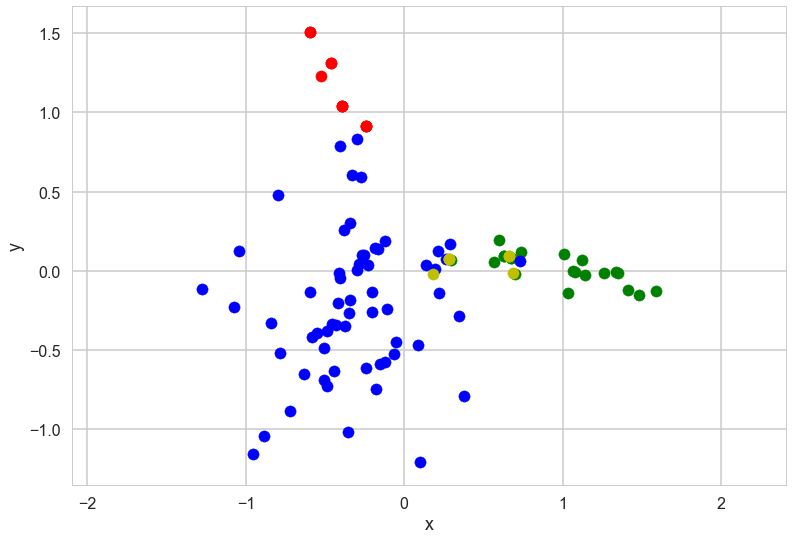

In [618]:
df_plot = pd.DataFrame()
df_plot['cluster_id'] = result_spcl
df_plot['x'] = x
df_plot['y'] = y

plt.scatter(df_plot[df_plot['cluster_id'] == 0]['x'], df_plot[df_plot['cluster_id'] == 0]['y'], c = 'g')
plt.scatter(df_plot[df_plot['cluster_id'] == 1]['x'], df_plot[df_plot['cluster_id'] == 1]['y'], c = 'b')
plt.scatter(df_plot[df_plot['cluster_id'] == 2]['x'], df_plot[df_plot['cluster_id'] == 2]['y'], c = 'r')
plt.scatter(df_plot[df_plot['cluster_id'] == 3]['x'], df_plot[df_plot['cluster_id'] == 3]['y'], c = 'y')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Agglomerative Clustering

For Agglomerative Clustering we use the parameters n_clusters = 4 and linkage = 'average' to achieve a rather high value of the Silhouette coefficient. The picture of clustering is identical to that seen in the method of Spectral Clustering. It looks less sensible than the picture obtained in the method of KMeans clustering.

In [640]:
from sklearn.cluster import AgglomerativeClustering

aggcl = AgglomerativeClustering(n_clusters=4, linkage = 'average').fit(x_cols)
labels = aggcl.labels_

result_aggcl = SpectralClustering(n_clusters=4).fit_predict(x_cols)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.277


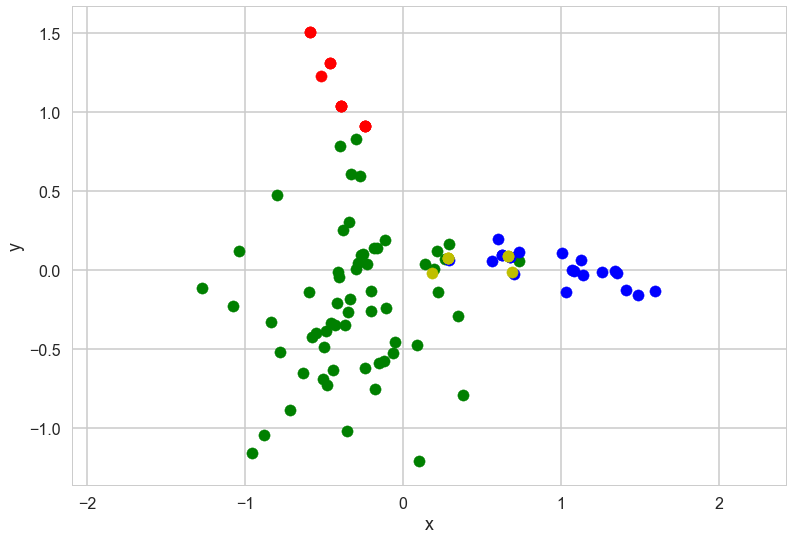

In [641]:
df_plot = pd.DataFrame()
df_plot['cluster_id'] = result_aggcl
df_plot['x'] = x
df_plot['y'] = y

plt.scatter(df_plot[df_plot['cluster_id'] == 0]['x'], df_plot[df_plot['cluster_id'] == 0]['y'], c = 'g')
plt.scatter(df_plot[df_plot['cluster_id'] == 1]['x'], df_plot[df_plot['cluster_id'] == 1]['y'], c = 'b')
plt.scatter(df_plot[df_plot['cluster_id'] == 2]['x'], df_plot[df_plot['cluster_id'] == 2]['y'], c = 'r')
plt.scatter(df_plot[df_plot['cluster_id'] == 3]['x'], df_plot[df_plot['cluster_id'] == 3]['y'], c = 'y')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### DBSCAN

I find this method rather particular. The results strongly depend on parameters eps and min_samples. The Silhouette Coefficient is small and the majority of samples are labeled as noisy samples which may be indicative of difficulties finding reliable clusterization for these data.

In [642]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_cols1 = x_cols.astype(float)
x_cols1 = StandardScaler().fit_transform(x_cols1)

#db = DBSCAN().fit(x_cols1)
db = DBSCAN(eps=3.5, min_samples=5).fit(x_cols1)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

result_db = DBSCAN(eps=3.0, min_samples=3).fit_predict(x_cols1)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_cols, labels))

Estimated number of clusters: 3
Silhouette Coefficient: 0.030


In [643]:
result_db

array([ 0, -1,  1,  0, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1,  1, -1,
       -1,  0, -1,  0, -1, -1, -1,  2, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1,  3, -1, -1, -1,  3,  1,  2,  0, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1,  2, -1,  0,  2, -1,  0, -1, -1,  0, -1,  0,  0, -1,  2, -1,
       -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,
        3,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1], dtype=int64)

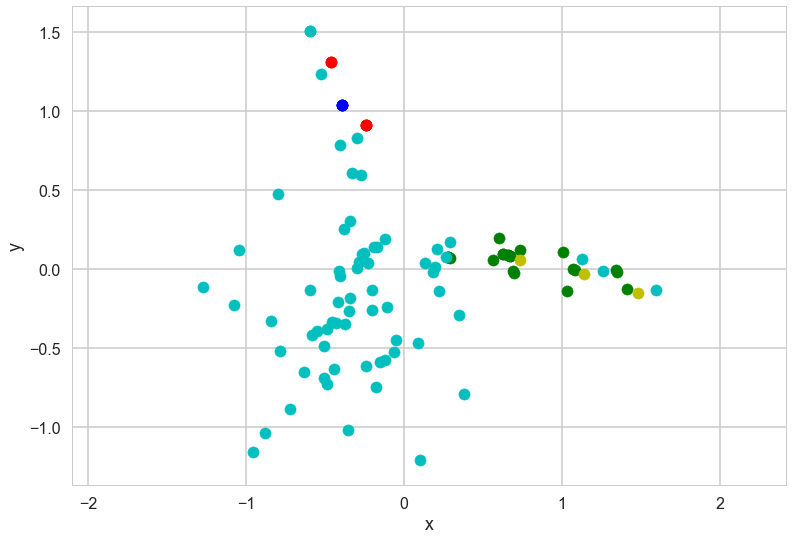

In [644]:
df_plot = pd.DataFrame()
df_plot['cluster_id'] = result_db
df_plot['x'] = x
df_plot['y'] = y

plt.scatter(df_plot[df_plot['cluster_id'] == 0]['x'], df_plot[df_plot['cluster_id'] == 0]['y'], c = 'g')
plt.scatter(df_plot[df_plot['cluster_id'] == 1]['x'], df_plot[df_plot['cluster_id'] == 1]['y'], c = 'b')
plt.scatter(df_plot[df_plot['cluster_id'] == 2]['x'], df_plot[df_plot['cluster_id'] == 2]['y'], c = 'r')
plt.scatter(df_plot[df_plot['cluster_id'] == 3]['x'], df_plot[df_plot['cluster_id'] == 3]['y'], c = 'y')
plt.scatter(df_pca[df_plot['cluster_id'] == -1]['x'], df_pca[df_plot['cluster_id'] == -1]['y'], c = 'c')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()